<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D,MaxPooling2D
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Conv2DTranspose, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

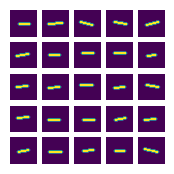

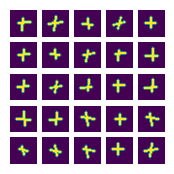

In [ ]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """
    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #1809

X_text: "9-4  " = y_text: "5  "


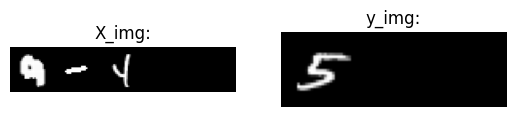


Query #4055

X_text: "20-27" = y_text: "-7 "


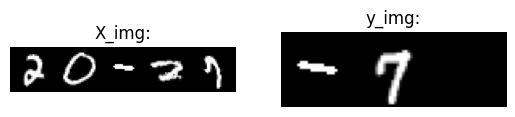


Query #6650

X_text: "33+25" = y_text: "58 "


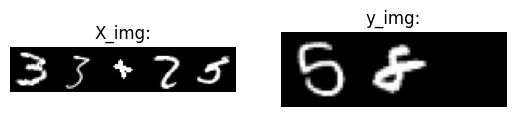


Query #6905

X_text: "34-52" = y_text: "-18"


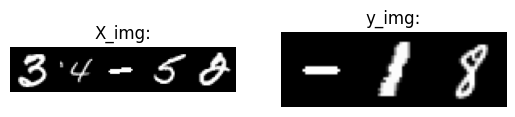


Query #691

X_text: "3-45 " = y_text: "-42"


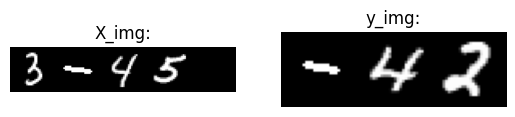


Query #777

X_text: "3-88 " = y_text: "-85"


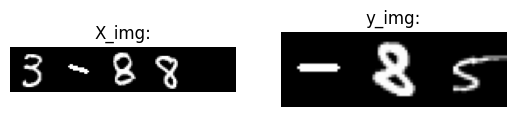


Query #5526

X_text: "27+63" = y_text: "90 "


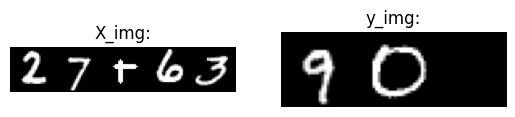


Query #1616

X_text: "8+8  " = y_text: "16 "


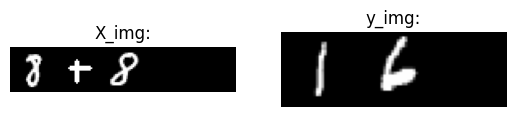


Query #6621

X_text: "33-10" = y_text: "23 "


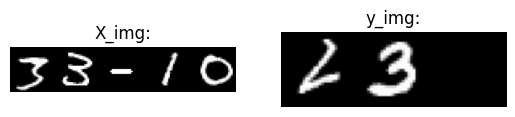


Query #7772

X_text: "38+86" = y_text: "124"


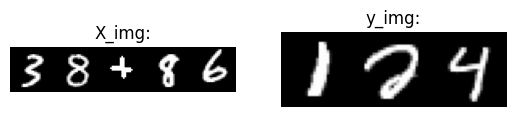

In [ ]:
# Illustrate the generated query/answer pairs
unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)
## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])
    print()

## Helper functions

The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():
    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))
    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()
    return text2text

# This is a structure of the text-to-text
It encodes the input sequence into a context vector and then decodes it to generate the output sequence.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

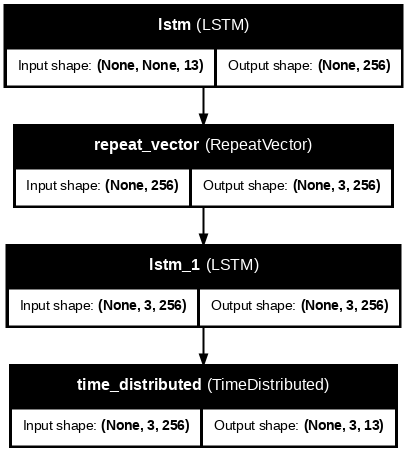

In [ ]:
from tensorflow.keras.utils import plot_model
model = build_text2text_model()
plot_model(model, to_file='image2text_model.png', show_shapes=True, show_layer_names=True, dpi=72)

# Different test set in text-text
This dataset is split into training and testing sets using different test sizes, defined by the split_number array, which includes various values such as 0.1, 0.25, 0.4, and so on. For each of these test sizes, the model is trained on the training data (x_train and y_train) using 20 epochs and a batch size of 32. After each training run, the model is evaluated on the test data (x_test and y_test), and both the test loss and test accuracy are recorded

In [ ]:
from sklearn.model_selection import train_test_split
X_text_onehot = encode_labels(X_text, max_len=5)
y_text_onehot = encode_labels(y_text, max_len=3)
split_number=[0.1,0.25,0.4,0.5,0.6,0.75,0.9]
all_histories = {}
for i in split_number:
  x_train, x_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, test_size=i)
  model = build_text2text_model()
  history = model.fit(x_train, y_train, epochs=20, batch_size=32)
  test_loss, test_accuracy = model.evaluate(x_test, y_test)
  all_histories[i] = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3458 - loss: 1.9670
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5068 - loss: 1.3563
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5668 - loss: 1.1848
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5997 - loss: 1.0836
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6197 - loss: 1.0152
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6450 - loss: 0.9528
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6581 - loss: 0.9199
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6644 - loss: 0.8879
Epoch 9/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6896 - loss: 0.8263
Epoch 10/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7279 - loss: 0.7204
Epoch 11/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7968 - loss: 0.5683
Epoch 12/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3368 - loss: 2.0057
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4881 - loss: 1.4201
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5439 - loss: 1.2397
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5840 - loss: 1.1258
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6111 - loss: 1.0461
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6289 - loss: 0.9949
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6364 - loss: 0.9717
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6560 - loss: 0.9224
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6634 - loss: 0.8974
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6820 - loss: 0.8519
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6989 - loss: 0.8025
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3264 - loss: 2.0475
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4566 - loss: 1.4946
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5330 - loss: 1.2999
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5669 - loss: 1.1937
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5882 - loss: 1.1160
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6037 - loss: 1.0661
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6197 - loss: 1.0281
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6321 - loss: 0.9888
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6489 - loss: 0.9477
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6548 - loss: 0.9268
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6637 - loss: 0.8971
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3184 - loss: 2.1201
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4357 - loss: 1.5712
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5150 - loss: 1.3413
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5524 - loss: 1.2275
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5843 - loss: 1.1394
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5943 - loss: 1.0920
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6134 - loss: 1.0388
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6203 - loss: 1.0228
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6292 - loss: 0.9838
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6384 - loss: 0.9632
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6460 - loss: 0.9496
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_4 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3009 - loss: 2.1507
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4194 - loss: 1.6407
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4772 - loss: 1.4348
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5269 - loss: 1.2904
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5576 - loss: 1.2103
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5719 - loss: 1.1500
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5915 - loss: 1.1071
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6020 - loss: 1.0670
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6258 - loss: 1.0216
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6254 - loss: 1.0061
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6361 - loss: 0.9911
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_5 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2768 - loss: 2.2369
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3954 - loss: 1.7501
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4346 - loss: 1.5888
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4717 - loss: 1.4700
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5020 - loss: 1.3728
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5213 - loss: 1.3059
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5391 - loss: 1.2661
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5632 - loss: 1.2050
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5696 - loss: 1.1721
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5890 - loss: 1.1185
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5950 - loss: 1.1024
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2286 - loss: 2.3660
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3618 - loss: 2.0026
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3991 - loss: 1.7832
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3989 - loss: 1.7268
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4196 - loss: 1.6719
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4357 - loss: 1.5655
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4456 - loss: 1.5605
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4724 - loss: 1.4964
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4935 - loss: 1.4090
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5131 - loss: 1.3688
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5212 - loss: 1.3394
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5146 - lo

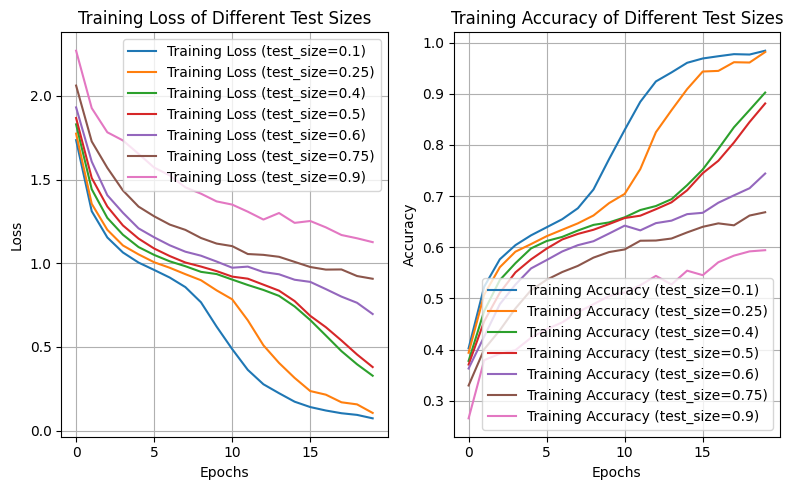

Test size: 0.1
Test Loss: 0.0522, Test Accuracy: 0.9905
------------------------------
Test size: 0.25
Test Loss: 0.1099, Test Accuracy: 0.9782
------------------------------
Test size: 0.4
Test Loss: 0.3153, Test Accuracy: 0.9014
------------------------------
Test size: 0.5
Test Loss: 0.4104, Test Accuracy: 0.8567
------------------------------
Test size: 0.6
Test Loss: 0.7266, Test Accuracy: 0.7218
------------------------------
Test size: 0.75
Test Loss: 0.9661, Test Accuracy: 0.6352
------------------------------
Test size: 0.9
Test Loss: 1.1807, Test Accuracy: 0.5808
------------------------------


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
for i, history in all_histories.items():
  axes[0].plot(history['loss'], label=f'Training Loss (test_size={i})')
axes[0].set_title('Training Loss of Different Test Sizes')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()
for i, history in all_histories.items():
  axes[1].plot(history['accuracy'], label=f'Training Accuracy (test_size={i})')
axes[1].set_title('Training Accuracy of Different Test Sizes')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()
plt.tight_layout()
plt.show()
for split, metrics in all_histories.items():
    print(f"Test size: {split}")
    print(f"Test Loss: {metrics['test_loss']:.4f}, Test Accuracy: {metrics['test_accuracy']:.4f}")
    print("-" * 30)

# Comparison the errors with test-size=0.3
### Description**
This code evaluates the performance of a text-to-text model by testing it with various test set and analyzing its errors.

*   Function:This function identifies misclassified samples by comparing the model's predictions (y_pred) with the true labels (y_test).It decodes the one-hot encoded outputs into human-readable text using the provided unique_characters list.It prints the total number of misclassified samples and displays the first 10 examples, including the input query, true result, and predicted result.

*   Testing with different split ratios:
    

1.   The code uses a range of test set sizes (split_number), like 10%, 25%, etc., to divide the dataset into training and test sets.
2.   For each split ratio, The dataset is split into training and testing subsets using train_test_split.A new model is built and trained using build_text2text_model and the training data.The trained model is tested, and its prediction errors are analyzed using the analyze_errors function.






In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split

def analyze_errors_and_length(model, x_test, y_test, x_test_text, y_test_text, unique_characters):
    def decode_output(output):
        return ''.join([unique_characters[np.argmax(i)] for i in output])
    y_pred = model.predict(x_test)
    misclassified_samples = [
        (x_test_text[idx], decode_output(y_test[idx]), decode_output(y_pred[idx]))
        for idx in range(len(x_test))
        if decode_output(y_test[idx]) != decode_output(y_pred[idx])
    ]
    print(f"Total Misclassified Samples: {len(misclassified_samples)}\n")
    error_by_length = defaultdict(int)
    length_count = defaultdict(int)
    large_errors = 0
    small_errors = 0
    unknown_errors = 0
    for query, true_label, predicted_label in misclassified_samples:
        query_no_spaces = query.replace(" ", "")
        query_length = len(query_no_spaces)
        error_by_length[query_length] += 1
        length_count[query_length] += 1
        try:
            true_value = float(true_label)
            predicted_value = float(predicted_label)
            value_diff = abs(true_value - predicted_value)
            if value_diff > 10:
                large_errors += 1
            elif 1 <= value_diff <= 9:
                small_errors += 1
            else:
                unknown_errors += 1
        except ValueError:
            unknown_errors += 1
        if len(misclassified_samples) <= 10:
            print(f"Query: {query} -> True Result: {true_label} -> Predicted Result: {predicted_label}")
    print("\nLength-based Misclassification Analysis:")
    lengths = sorted(error_by_length.keys())
    error_counts = [error_by_length[length] for length in lengths]
    total_counts = [length_count[length] for length in lengths]

    for i, length in enumerate(lengths):
        print(f"Length {length}: Total samples = {total_counts[i]}, Misclassified = {error_counts[i]}")
    print("\nError Type-based Misclassification Analysis:")
    print(f"Large Errors (>10 difference): {large_errors}")
    print(f"Small Errors (1-9 difference): {small_errors}")
    print(f"Unknown Errors (non-numeric or 0 difference): {unknown_errors}")

test_size = 0.3
x_train, x_test, y_train, y_test, x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(
    X_text_onehot, y_text_onehot, X_text, y_text, test_size=test_size
)
model = build_text2text_model()
model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)
analyze_errors_and_length(model, x_test, y_test, x_test_text, y_test_text, unique_characters)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_7 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3335 - loss: 2.0226
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4849 - loss: 1.4271
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5523 - loss: 1.2307
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5812 - loss: 1.1430
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6068 - loss: 1.0723
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6208 - loss: 1.0199
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6310 - loss: 0.9931
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6532 - loss: 0.9322
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6615 - loss: 0.8965
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6967 - loss: 0.8173
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7427 - loss: 0.6952
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

# Add additional LSTM layer to encoder networks
This code compares the performance (accuracy and loss) of models with different numbers of LSTM layers. The key steps involve training models with 1, 2, 3, and 4 LSTM layers, and then visualizing the results (training accuracy and loss) for each configuration.

By train models with different numbers of LSTM layers, We can observe how the number of layers affects the training accuracy and loss.



*   Model Construction:

The build_text2text_model function constructs a model with a dynamic number of LSTM layers, controlled by the num_encoder_layers parameter. This function uses the Sequential API in TensorFlow to stack multiple LSTM layers.

The first LSTM layer has return_sequences=True to pass sequences to subsequent LSTM layers.

*  Training and Evaluation:

For each configuration of LSTM layers (1 to 4), the model is trained with data split into training and test sets.

The fit function tracks the training accuracy and loss for each epoch.


In [ ]:
all_histories = {}
num_encoder_layers_list = [1, 2, 3, 4]
for num_encoder_layers in num_encoder_layers_list:
  def build_text2text_model(num_encoder_layers):
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    for _ in range(num_encoder_layers - 1):
        text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=False))
    text2text.add(RepeatVector(max_answer_length))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()
    return text2text
  X_text_onehot = encode_labels(X_text, max_len=5)
  y_text_onehot = encode_labels(y_text, max_len=3)
  x_train, x_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, test_size=0.1)
  model = build_text2text_model(num_encoder_layers=num_encoder_layers)
  history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
  test_loss, test_accuracy = model.evaluate(x_test, y_test)
  all_histories[num_encoder_layers] = {
      'loss': history.history['loss'],
      'accuracy': history.history['accuracy'],
      'test_loss': test_loss,
      'test_accuracy': test_accuracy
  }

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, None, 256)           │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,445 (5.08 MB)

 Trainable params: 1,330,445 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3474 - loss: 1.9778 - val_accuracy: 0.4113 - val_loss: 1.6045
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5036 - loss: 1.3611 - val_accuracy: 0.5893 - val_loss: 1.1413
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5892 - loss: 1.1150 - val_accuracy: 0.6130 - val_loss: 1.0344
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6208 - loss: 1.0118 - val_accuracy: 0.6133 - val_loss: 1.0110
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6359 - loss: 0.9598 - val_accuracy: 0.6193 - val_loss: 1.0071
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6456 - loss: 0.9279 - val_accuracy: 0.6248 - val_loss: 0.9903
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6541 - loss: 0.9006 - val_accuracy: 0.6483 - val_loss: 0.9183
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6635 - loss: 0.8720 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, None, 256)           │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,855,757 (7.08 MB)

 Trainable params: 1,855,757 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3439 - loss: 1.9902 - val_accuracy: 0.4709 - val_loss: 1.4119
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5281 - loss: 1.2855 - val_accuracy: 0.5987 - val_loss: 1.0467
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6046 - loss: 1.0525 - val_accuracy: 0.6263 - val_loss: 0.9919
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6298 - loss: 0.9732 - val_accuracy: 0.6541 - val_loss: 0.9092
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6433 - loss: 0.9309 - val_accuracy: 0.6554 - val_loss: 0.9023
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6578 - loss: 0.8952 - val_accuracy: 0.6530 - val_loss: 0.9000
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6626 - loss: 0.8727 - val_accuracy: 0.6702 - val_loss: 0.8454
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6729 - loss: 0.8487 - val_accuracy

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, None, 256)           │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,381,069 (9.08 MB)

 Trainable params: 2,381,069 (9.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3177 - loss: 2.0841 - val_accuracy: 0.4785 - val_loss: 1.4485
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5051 - loss: 1.3659 - val_accuracy: 0.6054 - val_loss: 1.0763
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5927 - loss: 1.0882 - val_accuracy: 0.6189 - val_loss: 1.0090
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6230 - loss: 1.0001 - val_accuracy: 0.6293 - val_loss: 0.9626
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6363 - loss: 0.9531 - val_accuracy: 0.6106 - val_loss: 0.9748
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6613 - loss: 0.8843 - val_accuracy: 0.6487 - val_loss: 0.9007
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6549 - loss: 0.9011 - val_accuracy: 0.6696 - val_loss: 0.8745
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6692 - loss: 0.8594 - val

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, None, 256)           │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_4 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,906,381 (11.09 MB)

 Trainable params: 2,906,381 (11.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3033 - loss: 2.1435 - val_accuracy: 0.4043 - val_loss: 1.6802
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4623 - loss: 1.5000 - val_accuracy: 0.5631 - val_loss: 1.2020
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5770 - loss: 1.1439 - val_accuracy: 0.6091 - val_loss: 1.0553
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6131 - loss: 1.0246 - val_accuracy: 0.6409 - val_loss: 0.9528
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6292 - loss: 0.9774 - val_accuracy: 0.6350 - val_loss: 0.9832
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6439 - loss: 0.9370 - val_accuracy: 0.6502 - val_loss: 0.9108
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6576 - loss: 0.8932 - val_accuracy: 0.6170 - val_loss: 0.9970
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6580 - loss: 0.8944 - val

In [ ]:
all_histories = {}
num_encoder_layers = 2
def build_text2text_model(num_encoder_layers):
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    # Add extra 2 LSTM layers based on num_encoder_layers
    for _ in range(num_encoder_layers - 1):
      text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=False))
    text2text.add(RepeatVector(max_answer_length))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()
    return text2text
X_text_onehot = encode_labels(X_text, max_len=5)
y_text_onehot = encode_labels(y_text, max_len=3)
x_train, x_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, test_size=0.1)
model = build_text2text_model(num_encoder_layers=num_encoder_layers)
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
test_loss, test_accuracy = model.evaluate(x_test, y_test)
all_histories[num_encoder_layers] = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
}

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, None, 256)           │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,855,757 (7.08 MB)

 Trainable params: 1,855,757 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3441 - loss: 1.9962 - val_accuracy: 0.4907 - val_loss: 1.3980
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5242 - loss: 1.3031 - val_accuracy: 0.5737 - val_loss: 1.1327
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6058 - loss: 1.0659 - val_accuracy: 0.6280 - val_loss: 0.9839
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6321 - loss: 0.9661 - val_accuracy: 0.6424 - val_loss: 0.9157
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6514 - loss: 0.9070 - val_accuracy: 0.6454 - val_loss: 0.9144
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6876 - loss: 0.8222 - val_accuracy: 0.7020 - val_loss: 0.7659
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7375 - loss: 0.6985 - val_accuracy: 0.7878 - val_loss: 0.5767
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7910 - loss: 0.5655 - val_accuracy:

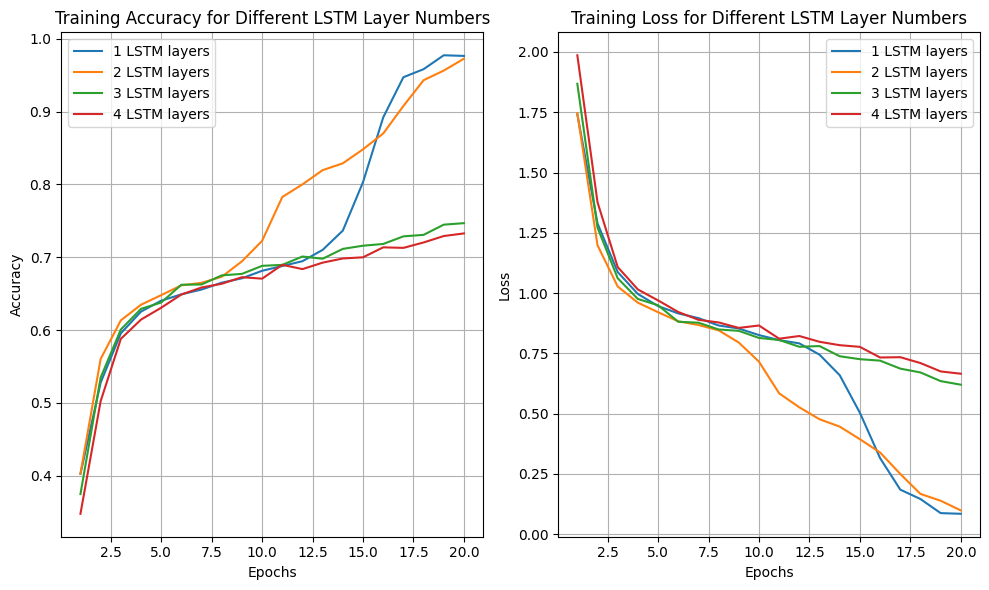

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for num_layers, history in all_histories.items():
    epochs = range(1, len(history['accuracy']) + 1)
    axs[0].plot(epochs, history['accuracy'], label=f'{num_layers} LSTM layers')
axs[0].set_title('Training Accuracy for Different LSTM Layer Numbers')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid()
for num_layers, history in all_histories.items():
    epochs = range(1, len(history['loss']) + 1)
    axs[1].plot(epochs, history['loss'], label=f'{num_layers} LSTM layers')

axs[1].set_title('Training Loss for Different LSTM Layer Numbers')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

# Errors in Different layers
In this section, we add LTSM layers in encoder process and record their performance. We used two dimensions to measure errors. The First one is errors types.



1.  The first method is of the wrong type. We define three types based on the  expected value and the actual value by calculating the difference between them. If the difference is greater than 10, it is considered a large error; if the difference is between 1 and 9, it is considered a small error; and if it cannot be recognized, it is classified as unknown or uncertain. We then calculate the number of occurrences for each type.

2. The second method calculates the error rate for each length based on the length of the input data.

We recorded the data for 1, 2, and 3 layers, and found that after 3 layers, the loss decreased more slowly, the error rate increased, and the performance declined.



In [ ]:
#2 LTSM layers
def build_text2text_model():
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    # Second additional LSTM layer
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=False))
    text2text.add(RepeatVector(max_answer_length))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()
    return text2text

In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split

def analyze_errors_and_length(model, x_test, y_test, x_test_text, y_test_text, unique_characters):
    def decode_output(output):
        return ''.join([unique_characters[np.argmax(i)] for i in output])

    y_pred = model.predict(x_test)
    misclassified_samples = [
        (x_test_text[idx], decode_output(y_test[idx]), decode_output(y_pred[idx]))
        for idx in range(len(x_test))
        if decode_output(y_test[idx]) != decode_output(y_pred[idx])
    ]
    print(f"Total Misclassified Samples: {len(misclassified_samples)}\n")

    error_by_length = defaultdict(int)
    length_count = defaultdict(int)
    large_errors = 0
    small_errors = 0
    unknown_errors = 0

    for query, true_label, predicted_label in misclassified_samples:
        query_no_spaces = query.replace(" ", "")
        query_length = len(query_no_spaces)
        error_by_length[query_length] += 1
        length_count[query_length] += 1

        try:
            true_value = float(true_label)
            predicted_value = float(predicted_label)
            value_diff = abs(true_value - predicted_value)
            if value_diff > 10:
                large_errors += 1
            elif 1 <= value_diff <= 9:
                small_errors += 1
            else:
                unknown_errors += 1
        except ValueError:
            unknown_errors += 1

        if len(misclassified_samples) <= 10:
            print(f"Query: {query} -> True Result: {true_label} -> Predicted Result: {predicted_label}")

    print("\nLength-based Misclassification Analysis:")
    lengths = sorted(error_by_length.keys())
    error_counts = [error_by_length[length] for length in lengths]
    total_counts = [length_count[length] for length in lengths]

    print("\nTotal counts and misclassification counts by query length (without spaces):")
    for length in lengths:
        total = length_count[length]
        misclassified = error_by_length[length]
        print(f"Length {length}: Total samples = {total}, Misclassified = {misclassified}")

    print("\nError Type-based Misclassification Analysis:")
    print(f"Large Errors (>10 difference): {large_errors}")
    print(f"Small Errors (1-9 difference): {small_errors}")
    print(f"Unknown Errors (non-numeric or 0 difference): {unknown_errors}")

test_size = 0.3
x_train, x_test, y_train, y_test, x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(
    X_text_onehot, y_text_onehot, X_text, y_text, test_size=test_size
)

model = build_text2text_model()
model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

analyze_errors_and_length(model, x_test, y_test, x_test_text, y_test_text, unique_characters)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 256)           │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,381,069 (9.08 MB)

 Trainable params: 2,381,069 (9.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3194 - loss: 2.0889
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4920 - loss: 1.4093
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5868 - loss: 1.1184
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6037 - loss: 1.0465
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6358 - loss: 0.9546
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6556 - loss: 0.9026
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6585 - loss: 0.8901
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6658 - loss: 0.8714
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6731 - loss: 0.8485
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6775 - loss: 0.8354
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6763 - loss: 0.8369
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#3 LTSM layers
def build_text2text_model():
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=False))
    text2text.add(RepeatVector(max_answer_length))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()
    return text2text

In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split

def analyze_errors_and_length(model, x_test, y_test, x_test_text, y_test_text, unique_characters):
    def decode_output(output):
        return ''.join([unique_characters[np.argmax(i)] for i in output])

    y_pred = model.predict(x_test)
    misclassified_samples = [
        (x_test_text[idx], decode_output(y_test[idx]), decode_output(y_pred[idx]))
        for idx in range(len(x_test))
        if decode_output(y_test[idx]) != decode_output(y_pred[idx])
    ]

    print(f"Total Misclassified Samples: {len(misclassified_samples)}\n")

    error_by_length = defaultdict(int)
    length_count = defaultdict(int)
    large_errors = 0
    small_errors = 0
    unknown_errors = 0

    for query, true_label, predicted_label in misclassified_samples:
        query_no_spaces = query.replace(" ", "")
        query_length = len(query_no_spaces)
        error_by_length[query_length] += 1
        length_count[query_length] += 1

        try:
            true_value = float(true_label)
            predicted_value = float(predicted_label)
            value_diff = abs(true_value - predicted_value)
            if value_diff > 10:
                large_errors += 1
            elif 1 <= value_diff <= 9:
                small_errors += 1
            else:
                unknown_errors += 1
        except ValueError:
            unknown_errors += 1

        if len(misclassified_samples) <= 10:
            print(f"Query: {query} -> True Result: {true_label} -> Predicted Result: {predicted_label}")

    print("\nLength-based Misclassification Analysis:")
    lengths = sorted(error_by_length.keys())
    error_counts = [error_by_length[length] for length in lengths]
    total_counts = [length_count[length] for length in lengths]

    print("\nTotal counts and misclassification counts by query length (without spaces):")
    for length in lengths:
        total = length_count[length]
        misclassified = error_by_length[length]
        print(f"Length {length}: Total samples = {total}, Misclassified = {misclassified}")

    print("\nError Type-based Misclassification Analysis:")
    print(f"Large Errors (>10 difference): {large_errors}")
    print(f"Small Errors (1-9 difference): {small_errors}")
    print(f"Unknown Errors (non-numeric or 0 difference): {unknown_errors}")

test_size = 0.3
x_train, x_test, y_train, y_test, x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(
    X_text_onehot, y_text_onehot, X_text, y_text, test_size=test_size
)

model = build_text2text_model()
model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

analyze_errors_and_length(model, x_test, y_test, x_test_text, y_test_text, unique_characters)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, None, 256)           │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 3, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 13)               │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,855,757 (7.08 MB)

 Trainable params: 1,855,757 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3282 - loss: 2.0561
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4862 - loss: 1.4177
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5899 - loss: 1.1126
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6229 - loss: 0.9970
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6347 - loss: 0.9610
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6540 - loss: 0.9013
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6609 - loss: 0.8864
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6690 - loss: 0.8576
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6816 - loss: 0.8302
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6843 - loss: 0.8219
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6797 - loss: 0.8346
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/s


---
---

## II. Image to text RNN Model


### Description**
we used Convolutional Neural Networks(CNN) with TimeDis-
tributed layers to extract features from images.These features
are then pass through an LSTM layer to generate a context
vector that caputures the image’s key information. Then the
decode we used another LSTM layer to generate a sequence
of word, outputting text step by step.The output at each step
is a probability distribution over all possible characters, using
a softmax activation. We choose this model to do experiment
because it performed better in test set and traing set.

In [ ]:
def build_image2text_model():
  image_input = Input(shape=(max_query_length, 28, 28, 1), name="Image_Input")
  x = TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same"), name="Conv2D_1")(image_input)
  x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_1")(x)
  x = TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding="same"), name="Conv2D_2")(x)
  x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_2")(x)
  x = TimeDistributed(Flatten(), name="Flatten")(x)
  encoded = LSTM(1024, return_sequences=False, dropout=0.3, name="Encoder_LSTM")(x)
  repeated_context = RepeatVector(max_answer_length, name="Repeat_Vector")(encoded)
  decoded = LSTM(1024, return_sequences=True, dropout=0.3, name="Decoder_LSTM")(repeated_context)
  output = TimeDistributed(Dense(len_unique_characters, activation='softmax'), name="Output_Layer")(decoded)
  model = Model(inputs=image_input, outputs=output, name="Image2Text_Model")
  model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
from sklearn.model_selection import train_test_split
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)
len_unique_characters = len(unique_characters)
x_train, x_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=0.3, random_state=42)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
model = build_image2text_model()
history = model.fit(x_train, y_train, epochs=20, batch_size=16)
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

x_train shape: (14000, 5, 28, 28), y_train shape: (14000, 3, 13)


Model: "Image2Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)             │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (TimeDistributed)           │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (TimeDistributed)     │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (TimeDistributed)           │ (None, 5, 14, 14, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (TimeDistributed)     │ (None, 5, 7, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (TimeDistributed)            │ (None, 5, 3136)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM (LSTM)                  │ (None, 1024)                │      17,043,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Repeat_Vector (RepeatVector)         │ (None, 3, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_LSTM (LSTM)                  │ (None, 3, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (TimeDistributed)       │ (None, 3, 13)               │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,468,301 (97.15 MB)

 Trainable params: 25,468,301 (97.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - accuracy: 0.3485 - loss: 1.9737
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.4773 - loss: 1.4346
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.5401 - loss: 1.2426
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.5793 - loss: 1.1390
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.6063 - loss: 1.0583
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.6260 - loss: 1.0007
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.6397 - loss: 0.9603
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.6552 - loss: 0.9236
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.6724 - loss: 0.8811
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.6853 - loss: 0.8460
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.7006 - loss: 0.8058
Epoch 12/20
875/875 ━━━━━━━━━━

# This is image-to-text structure


Model: "Image2Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)             │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (TimeDistributed)           │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (TimeDistributed)     │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (TimeDistributed)           │ (None, 5, 14, 14, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (TimeDistributed)     │ (None, 5, 7, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (TimeDistributed)            │ (None, 5, 3136)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM (LSTM)                  │ (None, 1024)                │      17,043,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Repeat_Vector (RepeatVector)         │ (None, 3, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_LSTM (LSTM)                  │ (None, 3, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (TimeDistributed)       │ (None, 3, 13)               │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,468,301 (97.15 MB)

 Trainable params: 25,468,301 (97.15 MB)

 Non-trainable params: 0 (0.00 B)

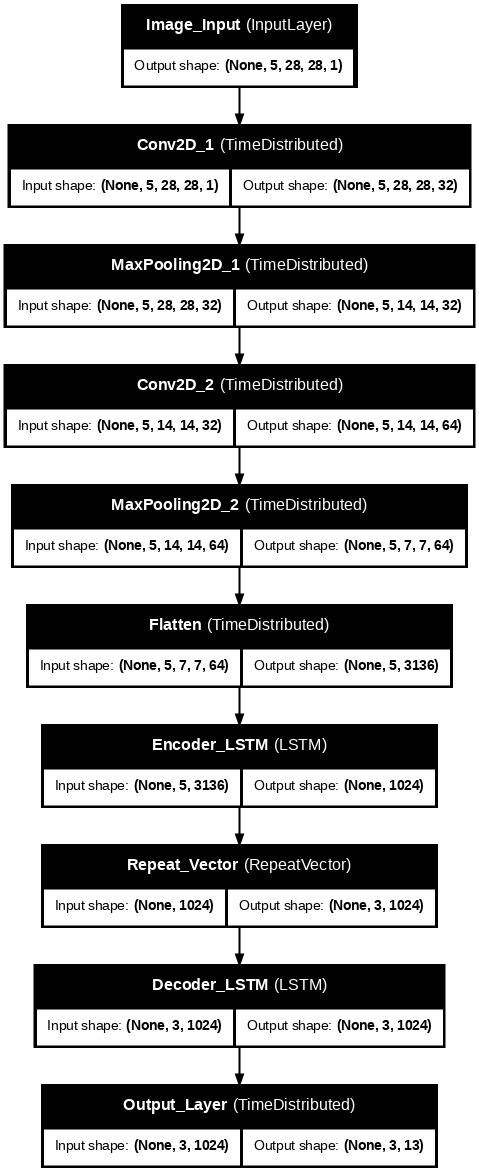

In [ ]:
from tensorflow.keras.utils import plot_model
model = build_image2text_model()
plot_model(model, to_file='image2text_model.png', show_shapes=True, show_layer_names=True, dpi=72)

#Mistakes types of image-to-text


The error types of outcomes are mainly two kinds when we com-
pare the incorrect results with the actual values. Firstly, errors are
classified into three categories: small-range errors (differences less
than 10), large-range errors (differences greater than 10), and unrec-
ognized errors (cases where there is no result due to low probability
among all classes).

In [ ]:
#Two LTSM layers
def build_image2text_model():
    image_input = Input(shape=(max_query_length, 28, 28, 1), name="Image_Input")
    x = TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same"), name="Conv2D_1")(image_input)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_1")(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding="same"), name="Conv2D_2")(x)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_2")(x)
    x = TimeDistributed(Flatten(), name="Flatten")(x)
    encoded_1 = LSTM(1024, return_sequences=True, dropout=0.3, name="Encoder_LSTM_1")(x)
    encoded_2 = LSTM(1024, return_sequences=False, dropout=0.3, name="Encoder_LSTM_2")(encoded_1)
    repeated_context = RepeatVector(max_answer_length, name="Repeat_Vector")(encoded_2)
    decoded = LSTM(1024, return_sequences=True, dropout=0.3, name="Decoder_LSTM")(repeated_context)
    output = TimeDistributed(Dense(len_unique_characters, activation='softmax'), name="Output_Layer")(decoded)
    model = Model(inputs=image_input, outputs=output, name="Image2Text_Model")
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    model.summary()
    return model
"""
#Three layers
def build_image2text_model():
    image_input = Input(shape=(max_query_length, 28, 28, 1), name="Image_Input")
    x = TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same"), name="Conv2D_1")(image_input)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_1")(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding="same"), name="Conv2D_2")(x)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_2")(x)
    x = TimeDistributed(Flatten(), name="Flatten")(x)

    encoded_1 = LSTM(1024, return_sequences=True, dropout=0.3, name="Encoder_LSTM_1")(x)
    encoded_2 = LSTM(1024, return_sequences=True, dropout=0.3, name="Encoder_LSTM_2")(encoded_1)
    encoded_3 = LSTM(1024, return_sequences=False, dropout=0.3, name="Encoder_LSTM_3")(encoded_2)

    repeated_context = RepeatVector(max_answer_length, name="Repeat_Vector")(encoded_3)
    decoded = LSTM(1024, return_sequences=True, dropout=0.3, name="Decoder_LSTM")(repeated_context)
    output = TimeDistributed(Dense(len_unique_characters, activation='softmax'), name="Output_Layer")(decoded)

    model = Model(inputs=image_input, outputs=output, name="Image2Text_Model")
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    model.summary()
    return model
"""

'\n#Three layers\ndef build_image2text_model():\n    image_input = Input(shape=(max_query_length, 28, 28, 1), name="Image_Input")\n    x = TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same"), name="Conv2D_1")(image_input)\n    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_1")(x)\n    x = TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding="same"), name="Conv2D_2")(x)\n    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_2")(x)\n    x = TimeDistributed(Flatten(), name="Flatten")(x)\n\n    encoded_1 = LSTM(1024, return_sequences=True, dropout=0.3, name="Encoder_LSTM_1")(x)\n    encoded_2 = LSTM(1024, return_sequences=True, dropout=0.3, name="Encoder_LSTM_2")(encoded_1)\n    encoded_3 = LSTM(1024, return_sequences=False, dropout=0.3, name="Encoder_LSTM_3")(encoded_2)\n\n    repeated_context = RepeatVector(max_answer_length, name="Repeat_Vector")(encoded_3)\n    decoded = LSTM(1024, return_sequences=True, dropout=0.3, name="Decoder_LST

In [ ]:
import numpy as np
import cv2
def count_non_zero_images(X_image):
  num_digits = 0
  for i in range(X_image.shape[0]):
    sub_image = X_image[i]
    if np.sum(sub_image > 0) > 0:
      num_digits += 1
  return num_digits

In [ ]:
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)
len_unique_characters = len(unique_characters)
x_train, x_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=0.3, random_state=42)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
model = build_image2text_model()
history = model.fit(x_train, y_train, epochs=5, batch_size=32)
predictions = model.predict(x_train)
num_digits_list = [count_non_zero_images(x) for x in x_train]
y_train_digits = np.array(num_digits_list)
for i in range(10):
    print(f"length: {y_train_digits[i]}, True: {decode_labels(y_train[i])}, Predicted: {decode_labels(predictions[i])}")

x_train shape: (14000, 5, 28, 28), y_train shape: (14000, 3, 13)


Model: "Image2Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)             │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (TimeDistributed)           │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (TimeDistributed)     │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (TimeDistributed)           │ (None, 5, 14, 14, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (TimeDistributed)     │ (None, 5, 7, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (TimeDistributed)            │ (None, 5, 3136)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 5, 1024)             │      17,043,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_2 (LSTM)                │ (None, 1024)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Repeat_Vector (RepeatVector)         │ (None, 3, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_LSTM (LSTM)                  │ (None, 3, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (TimeDistributed)       │ (None, 3, 13)               │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,861,005 (129.17 MB)

 Trainable params: 33,861,005 (129.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3280 - loss: 2.0752
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.4453 - loss: 1.5515
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5187 - loss: 1.3282
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.5627 - loss: 1.1953
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.5906 - loss: 1.1049
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
length: 4, True: 95 , Predicted: 85 
length: 5, True: 169, Predicted: 164
length: 5, True: 9  , Predicted: 1  
length: 5, True: 184, Predicted: 181
length: 5, True: 101, Predicted: 90 
length: 5, True: 39 , Predicted: 25 
length: 5, True: 9  , Predicted: 1  
length: 5, True: -33, Predicted: -33
length: 5, True: 78 , Predicted: 78 
length: 5, True: -1 , Predicted: -1 


In [ ]:
mismatch_count = 0
error_greater_than_10 = 0
error_between_1_and_9 = 0
unrecognized_errors = 0
for i in range(len(y_train)):
  true_labels = np.argmax(y_train[i], axis=-1)
  predicted_labels = np.argmax(predictions[i], axis=-1)
  if not np.array_equal(true_labels, predicted_labels):
      mismatch_count += 1
  try:
      diff = np.abs(predicted_labels - true_labels)
  except TypeError:
      diff = np.nan
      unrecognized_errors += 1
  if np.any(np.isnan(diff)):
      unrecognized_errors += 1
  elif np.any(diff > 10):
      error_greater_than_10 += 1
  elif np.any((diff >= 1) & (diff <= 9)):
      error_between_1_and_9 += 1
  elif np.all(predicted_labels == 0):
      unrecognized_errors += 1

print(f"Total number of mismatched predictions: {mismatch_count}")
print(f"Total errors with difference > 10: {error_greater_than_10}")
print(f"Total errors with difference between 1 and 9: {error_between_1_and_9}")
print(f"Total unrecognized errors (all zeros or undesired): {unrecognized_errors}")
total_errors = error_greater_than_10 + error_between_1_and_9 + unrecognized_errors

Total number of mismatched predictions: 12940
Total errors with difference > 10: 378
Total errors with difference between 1 and 9: 12397
Total unrecognized errors (all zeros or undesired): 0


In [ ]:
import numpy as np
import cv2
def count_non_zero_images(X_image):
  num_digits = 0
  for i in range(X_image.shape[0]):
    sub_image = X_image[i]
    if np.sum(sub_image > 0) > 0:
      num_digits += 1
  return num_digits

In [ ]:
import numpy as np
num_digits_list = [count_non_zero_images(x) for x in x_train]
y_train_digits = np.array(num_digits_list)
lengths_inconsistency = {}
for i in range(len(x_train)):
    true_label = decode_labels(y_train[i])
    predicted_label = decode_labels(predictions[i])
    num_digits = y_train_digits[i]
    if len(true_label) == len(predicted_label):
        if true_label != predicted_label:
            if num_digits not in lengths_inconsistency:
                lengths_inconsistency[num_digits] = 0
            lengths_inconsistency[num_digits] += 1
    else:
        if num_digits not in lengths_inconsistency:
            lengths_inconsistency[num_digits] = 0
        lengths_inconsistency[num_digits] += 1
for length, count in lengths_inconsistency.items():
    print(f"Length {length}: {count} inconsistencies")


Length 4: 2308 inconsistencies
Length 5: 10510 inconsistencies
Length 3: 122 inconsistencies


#Different test size

We tried multiple different splits for your training
and test sets (50% train - 50% test; 25% train - 75% test, 10% train, 90% test etc.) and evaluate the
accuracy and generalization capability of your models.

As a result,On training set , the smallest train-test split ratio of 10%-90%
performs best (as shown in Figure12) as more training data is avail-
able for the model to learn from. Conversely, with smaller training
sets, the model might underfit, leading to higher loss values and
low accuracy.

In [ ]:
from sklearn.model_selection import train_test_split
y_text_onehot = encode_labels(y_text, max_len=3)
split_number=[0.1,0.25,0.4,0.5,0.6,0.75,0.9]
all_histories = {}
for i in split_number:
  x_train, x_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=i)
  model = build_image2text_model()
  history = model.fit(x_train, y_train, epochs=20, batch_size=3)
  test_loss, test_accuracy = model.evaluate(x_test, y_test)
  all_histories[i] = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
}

Epoch 1/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.3726 - loss: 1.8867
Epoch 2/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.4491 - loss: 1.5396
Epoch 3/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.4828 - loss: 1.4185
Epoch 4/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.5160 - loss: 1.3227
Epoch 5/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.5406 - loss: 1.2620
Epoch 6/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.5523 - loss: 1.2072
Epoch 7/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.5655 - loss: 1.1763
Epoch 8/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.5835 - loss: 1.1370
Epoch 9/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.5935 - loss: 1.1066
Epoch 10/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.6022 - loss: 1.0811
Epoch 11/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.6132 - loss: 1.0540
Epoch 12/20
6000/60

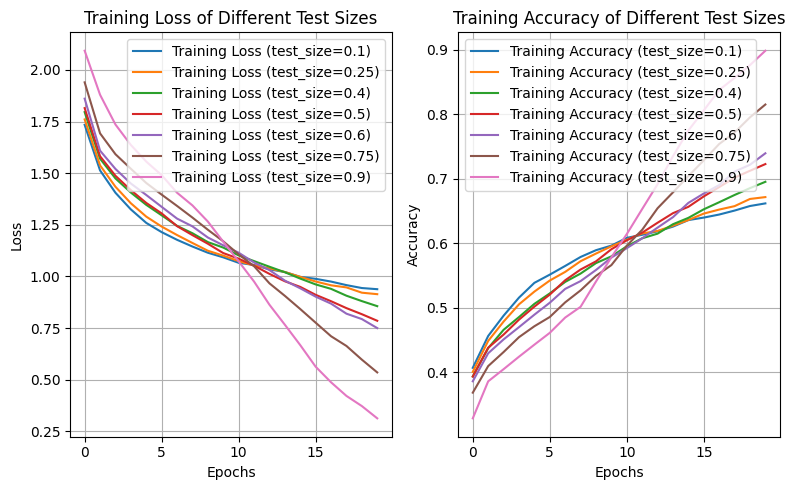

Test size: 0.1
Test Loss: 1.3640, Test Accuracy: 0.5472
------------------------------
Test size: 0.25
Test Loss: 1.4622, Test Accuracy: 0.5357
------------------------------
Test size: 0.4
Test Loss: 1.6236, Test Accuracy: 0.5122
------------------------------
Test size: 0.5
Test Loss: 1.7825, Test Accuracy: 0.4993
------------------------------
Test size: 0.6
Test Loss: 1.8875, Test Accuracy: 0.4776
------------------------------
Test size: 0.75
Test Loss: 2.4222, Test Accuracy: 0.4400
------------------------------
Test size: 0.9
Test Loss: 3.1256, Test Accuracy: 0.3965
------------------------------


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
for i, history in all_histories.items():
    axes[0].plot(history['loss'], label=f'Training Loss (test_size={i})')
axes[0].set_title('Training Loss of Different Test Sizes')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()
for i, history in all_histories.items():
    axes[1].plot(history['accuracy'], label=f'Training Accuracy (test_size={i})')
axes[1].set_title('Training Accuracy of Different Test Sizes')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()
plt.tight_layout()
plt.show()
for split, metrics in all_histories.items():
    print(f"Test size: {split}")
    print(f"Test Loss: {metrics['test_loss']:.4f}, Test Accuracy: {metrics['test_accuracy']:.4f}")
    print("-" * 30)


# Comparison the outputs
In this part, we used Three ways to build this model.  It uses LSTM layers to encode a sequence of images into a fixed-size vector and then decodes it into a sequence of characters. The model includes dropout for regularization and uses the softmax activation function in the output layer for multi-class classification. It is compiled with categorical cross-entropy loss and the Adam optimizer for training.


We found this model is overfitting.

In [ ]:
#another approach
def build_image2text_model():
  image_input = Input(shape=(max_query_length, 28, 28, 1), name="Image_Input")
  flattened_images = TimeDistributed(Flatten(), name="Flatten_Images")(image_input)
  encoded = LSTM(512, return_sequences=False, dropout=0.3)(flattened_images)
  repeated_context = RepeatVector(max_answer_length)(encoded)
  decoded = LSTM(512, return_sequences=True, dropout=0.3)(repeated_context)
  output = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(decoded)
  model = Model(inputs=image_input, outputs=output)
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

In [ ]:
from sklearn.model_selection import train_test_split
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)
x_train, x_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=0.3, random_state=42)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
model = build_image2text_model()
history = model.fit(x_train, y_train, epochs=20, batch_size=16)
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

x_train shape: (14000, 5, 28, 28), y_train shape: (14000, 3, 13)
Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3482 - loss: 1.9996
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4282 - loss: 1.6142
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4628 - loss: 1.4979
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4824 - loss: 1.4174
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5098 - loss: 1.3429
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5345 - loss: 1.2746
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5550 - loss: 1.2075
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5749 - loss: 1.1558
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5927 - loss: 1.1149
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6113 - loss: 1.0571
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6269 - 

# Add LTSM layers


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, TimeDistributed, Conv2D, MaxPooling2D, Flatten, RepeatVector, Dense
from tensorflow.keras.optimizers import Adam
def build_image2text_model(num_encoder_layers):
    image_input = Input(shape=(max_query_length, 28, 28, 1), name="Image_Input")
    x = TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same"), name="Conv2D_1")(image_input)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_1")(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding="same"), name="Conv2D_2")(x)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="MaxPooling2D_2")(x)
    x = TimeDistributed(Flatten(), name="Flatten")(x)
    for i in range(num_encoder_layers - 1):
        x = LSTM(1024, return_sequences=True, dropout=0.3, name=f"Encoder_LSTM_{i+1}")(x)
    encoded = LSTM(1024, return_sequences=False, dropout=0.3, name=f"Encoder_LSTM_{num_encoder_layers}")(x)
    repeated_context = RepeatVector(max_answer_length, name="Repeat_Vector")(encoded)
    decoded = LSTM(1024, return_sequences=True, dropout=0.3, name="Decoder_LSTM")(repeated_context)
    output = TimeDistributed(Dense(len_unique_characters, activation='softmax'), name="Output_Layer")(decoded)
    model = Model(inputs=image_input, outputs=output, name="Image2Text_Model")
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)
len_unique_characters = len(unique_characters)
x_train, x_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=0.3, random_state=42)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
all_histories = {}
num_encoder_layers_list = [1, 2, 3, 4]
for num_encoder_layers in num_encoder_layers_list:
    print(f"\nTraining with {num_encoder_layers} encoder layers")
    model = build_image2text_model(num_encoder_layers=num_encoder_layers)
    history = model.fit(x_train, y_train, epochs=20, batch_size=16)
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    all_histories[num_encoder_layers] = {
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
    }

x_train shape: (14000, 5, 28, 28), y_train shape: (14000, 3, 13)

Training with 1 encoder layers


Model: "Image2Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)             │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (TimeDistributed)           │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (TimeDistributed)     │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (TimeDistributed)           │ (None, 5, 14, 14, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (TimeDistributed)     │ (None, 5, 7, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (TimeDistributed)            │ (None, 5, 3136)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 1024)                │      17,043,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Repeat_Vector (RepeatVector)         │ (None, 3, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_LSTM (LSTM)                  │ (None, 3, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (TimeDistributed)       │ (None, 3, 13)               │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,468,301 (97.15 MB)

 Trainable params: 25,468,301 (97.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.3513 - loss: 1.9835
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4773 - loss: 1.4359
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.5367 - loss: 1.2512
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.5808 - loss: 1.1324
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.6087 - loss: 1.0557
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.6275 - loss: 0.9967
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.6455 - loss: 0.9492
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.6638 - loss: 0.8996
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.6740 - loss: 0.8718
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.6892 - loss: 0.8352
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.7117 - loss: 0.7804
Epoch 12/20
875/875 ━━━━━━━━━━

Model: "Image2Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)             │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (TimeDistributed)           │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (TimeDistributed)     │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (TimeDistributed)           │ (None, 5, 14, 14, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (TimeDistributed)     │ (None, 5, 7, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (TimeDistributed)            │ (None, 5, 3136)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 5, 1024)             │      17,043,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_2 (LSTM)                │ (None, 1024)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Repeat_Vector (RepeatVector)         │ (None, 3, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_LSTM (LSTM)                  │ (None, 3, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (TimeDistributed)       │ (None, 3, 13)               │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,861,005 (129.17 MB)

 Trainable params: 33,861,005 (129.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.3425 - loss: 2.0271
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.4505 - loss: 1.5236
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.5242 - loss: 1.3042
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.5721 - loss: 1.1544
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6033 - loss: 1.0667
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6227 - loss: 1.0110
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6378 - loss: 0.9698
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6468 - loss: 0.9438
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6604 - loss: 0.9034
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6715 - loss: 0.8779
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.6773 - loss: 0.8595
Epoch 12/20
875/875 ━━━━━━━━━━

Model: "Image2Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)             │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (TimeDistributed)           │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (TimeDistributed)     │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (TimeDistributed)           │ (None, 5, 14, 14, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (TimeDistributed)     │ (None, 5, 7, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (TimeDistributed)            │ (None, 5, 3136)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 5, 1024)             │      17,043,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_2 (LSTM)                │ (None, 5, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_3 (LSTM)                │ (None, 1024)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Repeat_Vector (RepeatVector)         │ (None, 3, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_LSTM (LSTM)                  │ (None, 3, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (TimeDistributed)       │ (None, 3, 13)               │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,253,709 (161.19 MB)

 Trainable params: 42,253,709 (161.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step - accuracy: 0.3212 - loss: 2.0829
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.4426 - loss: 1.5562
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.5179 - loss: 1.3287
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.5532 - loss: 1.2205
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.5823 - loss: 1.1337
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.5983 - loss: 1.0765
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.6126 - loss: 1.0289
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.6281 - loss: 0.9913
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.6362 - loss: 0.9634
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.6507 - loss: 0.9316
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.6520 - loss: 0.9214
Epoch 12/20
875/875 ━━━━━━━━━━

Model: "Image2Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)             │ (None, 5, 28, 28, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (TimeDistributed)           │ (None, 5, 28, 28, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (TimeDistributed)     │ (None, 5, 14, 14, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (TimeDistributed)           │ (None, 5, 14, 14, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (TimeDistributed)     │ (None, 5, 7, 7, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (TimeDistributed)            │ (None, 5, 3136)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 5, 1024)             │      17,043,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_2 (LSTM)                │ (None, 5, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_3 (LSTM)                │ (None, 5, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_4 (LSTM)                │ (None, 1024)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Repeat_Vector (RepeatVector)         │ (None, 3, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_LSTM (LSTM)                  │ (None, 3, 1024)             │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (TimeDistributed)       │ (None, 3, 13)               │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,646,413 (193.20 MB)

 Trainable params: 50,646,413 (193.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step - accuracy: 0.3101 - loss: 2.1145
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.3958 - loss: 1.8254
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.4621 - loss: 1.5055
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.5184 - loss: 1.3391
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.5524 - loss: 1.2474
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.5793 - loss: 1.1650
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.5938 - loss: 1.1276
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.6117 - loss: 1.0695
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.6228 - loss: 1.0269
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.6397 - loss: 0.9834
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.6499 - loss: 0.9551
Epoch 12/20
875/875 ━━━━━━━━━━

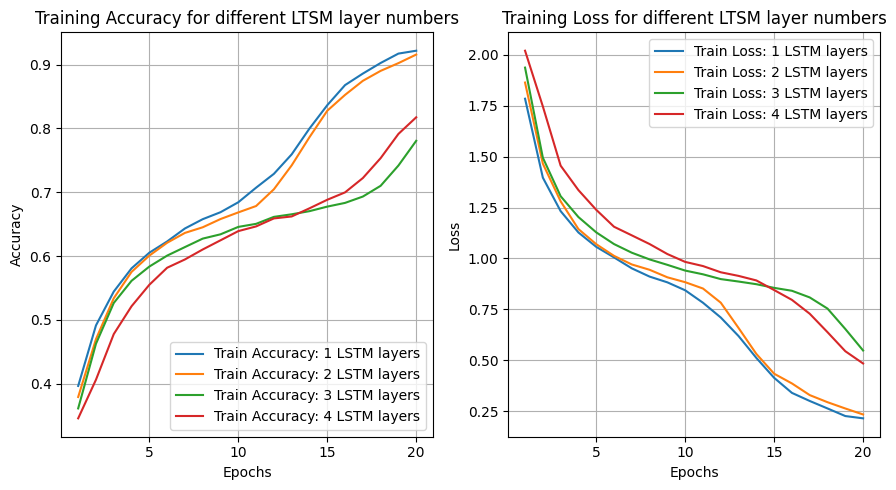

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
for num_layers, history in all_histories.items():
    epochs = range(1, len(history['accuracy']) + 1)
    axs[0].plot(epochs, history['accuracy'], label=f'Train Accuracy: {num_layers} LSTM layers')
axs[0].set_title('Training Accuracy for different LTSM layer numbers')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid()
for num_layers, history in all_histories.items():
    epochs = range(1, len(history['loss']) + 1)
    axs[1].plot(epochs, history['loss'], label=f'Train Loss: {num_layers} LSTM layers')
axs[1].set_title('Training Loss for different LTSM layer numbers')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()


---
---

## III. Text to image RNN Model
### Description**
 This Text-to-Image model combines LSTM for encoding the input text and Conv2DTranspose layers for progressively upscaling the feature map to generate an image. Firstly, the text is encoded into a vextore by the LTSM layer, then tranformed through a dense into a 7*7*128 tensor.TWo decovolutional layers upsamples the feature map, increasing spatial deimensions to generate the final image. The model uses binary crossentropy as the loss function and use Adam optimizer to produce a visual representation from the input text.



In [ ]:
from tensorflow.keras.layers import Input, Conv2DTranspose, Dense, Permute
def build_test2image_model():
    encoder_inputs = Input(shape=(max_query_length, len(unique_characters)), name="Encoder_Input")
    encoder_lstm = LSTM(256, return_sequences=False, name="Encoder_LSTM")
    encoder_output = encoder_lstm(encoder_inputs)
    decoder_dense = Dense(7 * 7 * 128, activation='relu', name="Decoder_Dense")(encoder_output)
    decoder_reshape = Reshape((7, 7, 128), name="Decoder_Reshape")(decoder_dense)
    decoder_deconv1 = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu", name="Deconv1")(decoder_reshape)
    decoder_deconv2 = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu", name="Deconv2")(decoder_deconv1)
    decoder_output = Conv2DTranspose(max_answer_length, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="Deconv_Output")(decoder_deconv2)
    decoder_output = Permute((3, 1, 2), name="Permute_Output")(decoder_output)
    model = Model(encoder_inputs, decoder_output, name="Text_to_Image_Model")
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['binary_accuracy'])
    return model

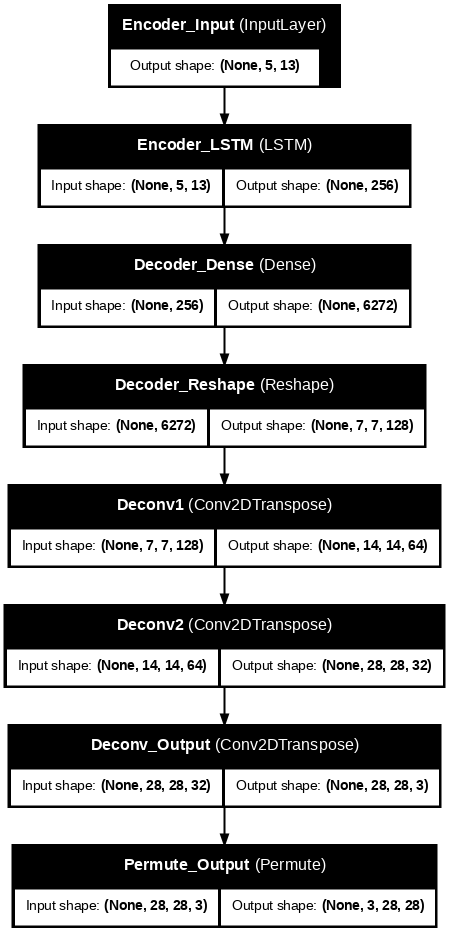

In [ ]:
from tensorflow.keras.utils import plot_model
model = build_test2image_model()
plot_model(model, to_file='image2text_model.png', show_shapes=True, show_layer_names=True, dpi=72)

# Results of text-to-image model
We recorded the loss and binary-accuracy.The fall of
the loss function indicates that the model’s predictions get closer
to the true values.There are many reasons to result in the accu-
racy flutuating like learning rate too high, imbalanced data and
optimaizer configuration issues.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_text_onehot, y_img, test_size=0.2)
print(X_text_onehot.shape)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
model1=build_test2image_model()
history = model1.fit(X_text_onehot, y_img, batch_size=32, epochs=50)
test_loss = model1.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")

(20000, 5, 13)
x_train shape: (16000, 5, 13), y_train shape: (16000, 3, 28, 28)
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.8597 - loss: 0.2786
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.8649 - loss: 0.1953
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8636 - loss: 0.1883
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8633 - loss: 0.1855
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8622 - loss: 0.1848
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8624 - loss: 0.1839
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8619 - loss: 0.1828
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8619 - loss: 0.1818
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8607 - loss: 0.1813
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8613 - lo

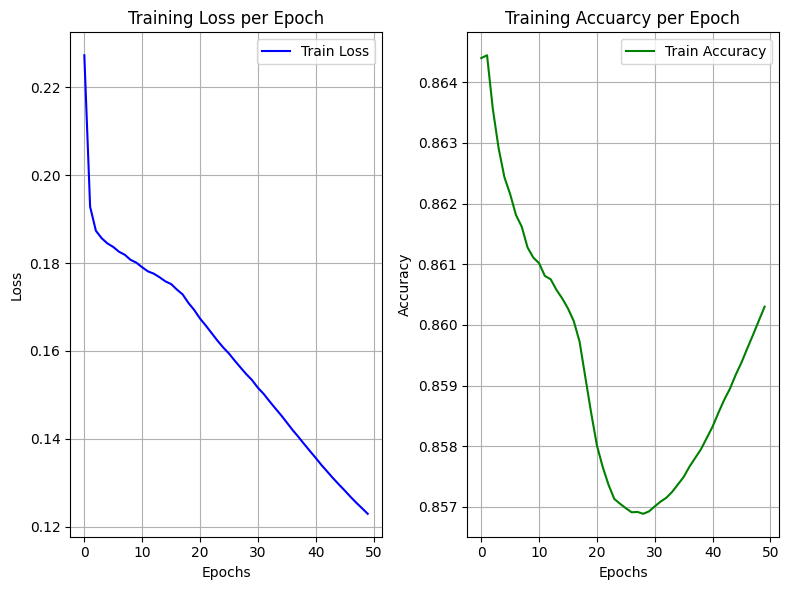

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy', color='green')
plt.title('Training Accuarcy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# output of text-to-image model

 The
images are generated with model using LSTMs to processes data
one step at a time, leading to accumulated errors, distortion, and
loss of details in the output, ultimately resulting in low quality of
images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Predicted images shape: (3, 28, 28)
(20000, 3, 28, 28)
Pixel value range: 0.0, 0.9419921636581421
Query: 6+12 


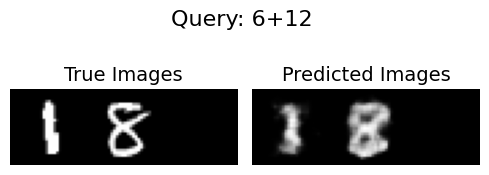

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted images shape: (3, 28, 28)
(20000, 3, 28, 28)
Pixel value range: 0.0, 0.9665033221244812
Query: 3-59 


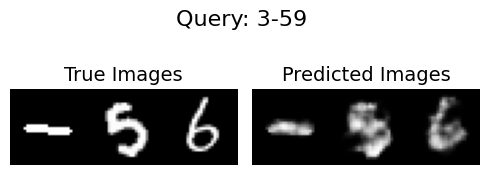

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted images shape: (3, 28, 28)
(20000, 3, 28, 28)
Pixel value range: 0.0, 0.9724738597869873
Query: 19+71


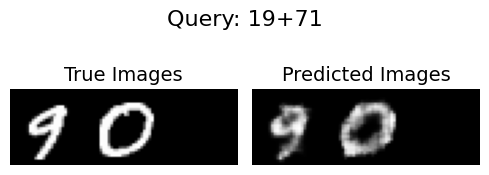

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted images shape: (3, 28, 28)
(20000, 3, 28, 28)
Pixel value range: 2.1361006201325836e-33, 0.977689802646637
Query: 14-96


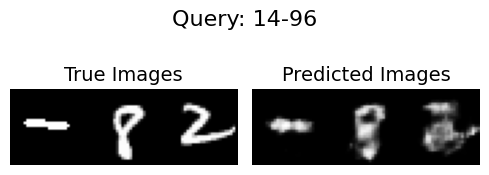

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted images shape: (3, 28, 28)
(20000, 3, 28, 28)
Pixel value range: 0.0, 0.8693708777427673
Query: 8+41 


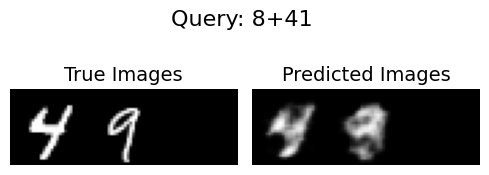

In [ ]:
def visualize_prediction(idx):
    query = X_text[idx]
    true_images = y_img[idx]
    predicted_images = model1.predict(np.expand_dims(X_text_onehot[idx], axis=0))[0]
    print(f"Predicted images shape: {predicted_images.shape}")
    print(y_img.shape)
    print(f"Pixel value range: {np.min(predicted_images)}, {np.max(predicted_images)}")
    true_combined = np.hstack([true_images[i].reshape(28, 28) for i in range(max_answer_length)])
    predicted_combined = np.hstack([predicted_images[i].reshape(28, 28) for i in range(max_answer_length)])
    print(f"Query: {query}")
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(true_combined, cmap='gray')
    plt.title("True Images", fontsize=14)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_combined, cmap='gray')
    plt.title("Predicted Images", fontsize=14)
    plt.axis('off')
    plt.suptitle(f"Query: {query}", fontsize=16, y=0.7)
    plt.tight_layout()
    plt.show()
for _ in range(5):
    idx = np.random.randint(0, len(x_test))
    visualize_prediction(idx)

# A separate supervised model
We designed a supervised model using CNNs to evaluate the
generated images of the Text-to-Image model. However, due to the
low quality of the generated images, the CNN failed to accurately
recognize the digits in the images. Therefore, it is inefficient in
evaluating the Text-to-Image model.

Firstly, we can X-text to calculate the answer.It starts by flattening the input and then adds two fully connected (dense) layers with ReLU activation. The final layer has a single neuron to output a continuous value. The model is compiled with the Adam optimizer, mean squared error (MSE) loss function, and mean absolute error (MAE) as a metric.

In [ ]:
def calculate_addition_result(text_queries):
    results = []
    for query in text_queries:
        query = query.strip()
        if '+' in query:
            num1, num2 = query.split('+')
            operator = '+'
        elif '-' in query:
            num1, num2 = query.split('-')
            operator = '-'
        else:
            raise ValueError(f"Unrecognized format: {query}")
        num1 = int(num1.strip())
        num2 = int(num2.strip())
        if operator == '+':
            result = num1 + num2
        elif operator == '-':
            result = num1 - num2
        results.append(result)
    return results

def decode_labels(labels):
    predicted = []
    for label in labels:
        pred = np.argmax(label, axis=1)
        predicted_str = ''.join([unique_characters[i] for i in pred])
        predicted.append(predicted_str)
    return predicted
X=decode_labels(x_train)
print(X[:10])
y_num = calculate_addition_result(decode_labels(x_train))
print(y_num)

['34-97', '32-73', '81-53', '42+38', '50+22', '91-11', '65+18', '49-72', '94+8 ', '22+74']
[-63, -41, 28, 80, 72, 80, 83, -23, 102, 96, 67, 83, 117, 146, 63, 88, 167, -3, 108, -10, 125, 139, 163, 72, 180, 26, 40, 114, 23, 117, 115, 143, -93, 92, -4, 15, 67, 2, 3, 3, 106, 102, 65, -13, 31, 8, 41, 155, 152, 33, 94, -88, 38, 17, 3, 112, 56, 6, -43, -3, 184, 8, -41, 115, 45, 58, 96, 131, 43, 57, 93, -35, 59, -1, 164, 167, 97, 32, 109, 144, -32, 38, 0, 88, 54, 130, 33, 139, 34, 62, 9, -9, -16, -30, -50, -78, 156, 90, 45, 52, 51, 44, 99, -40, 125, 60, -14, -2, 23, 158, -30, 57, -11, 52, 1, -2, 94, 119, 174, 97, 103, 161, 86, 28, 98, -71, 87, 106, 155, 66, -52, 165, 112, -7, 55, 16, -82, 57, 65, -66, 40, 109, 42, 178, 161, 0, 47, 135, 115, 26, 70, 106, 31, -24, 27, -41, 105, 84, 72, -5, 86, 149, 163, 31, 79, 159, 134, 64, -56, 113, -64, -14, 30, 131, 151, 179, -45, 13, 43, 70, -6, 122, 88, 7, -63, 100, 99, -16, -6, 29, 35, 105, 122, 88, -2, 4, 138, 99, 13, -10, 79, 70, 18, 132, 65, 126, 139, 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
def build_regression_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model
X = model1.predict(x_train)
print(X.shape)

X = np.transpose(X, (0, 2, 3, 1))
print(X.shape)
input_shape = (28, 28, 3)
model = build_regression_model(input_shape)
history = model.fit(X, np.array(y_num), batch_size=32, epochs=10)
predicted_values = model.predict(X)
predicted_values = np.round(predicted_values).astype(int)
y_num = np.array(y_num)
correct_predictions = (predicted_values.flatten() == y_num.flatten())
accuracy = np.mean(correct_predictions)
print(f"Prediction accuracy: {accuracy * 100:.2f}%")
for i in range(10):
    print(f"Input: {x_train[i]} - Predicted: {predicted_values[i][0]} - Actual: {y_num[i]}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(16000, 3, 28, 28)
(16000, 28, 28, 3)
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1772.7743 - mae: 29.7891
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 167.5282 - mae: 9.5899
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 117.7228 - mae: 7.9112
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 92.1425 - mae: 7.0635
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 82.9572 - mae: 6.7041
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 71.2292 - mae: 6.1675
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 65.5048 - mae: 5.9123
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61.4758 - mae: 5.7349
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49.7652 - mae: 5.1232
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 47.2121 - mae: 4.9730
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Prediction accuracy: 7.72%
Input: [[0. 0. 0. 1. 0. 0. 

# different encoder layer
 Like other models, we also used different layers to measure this model's performance.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape, Conv2DTranspose, Permute
from tensorflow.keras.optimizers import Adam
def build_text2image_model(num_encoder_layers):
    encoder_inputs = Input(shape=(max_query_length, len(unique_characters)), name="Encoder_Input")
    x = encoder_inputs
    for i in range(num_encoder_layers - 1):
        x = LSTM(256, return_sequences=True, name=f"Encoder_LSTM_{i+1}")(x)
    encoder_output = LSTM(256, return_sequences=False, name=f"Encoder_LSTM_{num_encoder_layers}")(x)
    decoder_dense = Dense(7 * 7 * 128, activation='relu', name="Decoder_Dense")(encoder_output)
    decoder_reshape = Reshape((7, 7, 128), name="Decoder_Reshape")(decoder_dense)
    decoder_deconv1 = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu", name="Deconv1")(decoder_reshape)
    decoder_deconv2 = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu", name="Deconv2")(decoder_deconv1)
    decoder_output = Conv2DTranspose(max_answer_length, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="Deconv_Output")(decoder_deconv2)
    decoder_output = Permute((3, 1, 2), name="Permute_Output")(decoder_output)
    model = Model(encoder_inputs, decoder_output, name="Text_to_Image_Model")
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])
    model.summary()
    return model

In [ ]:
from sklearn.model_selection import train_test_split
num_encoder_layers_list = [1, 2, 3, 4]
all_histories = {}
X_text_onehot = encode_labels(X_text, max_len=5)
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)
x_train, x_test, y_train, y_test = train_test_split(X_text_onehot, y_img, test_size=0.3, random_state=42)
for num_encoder_layers in num_encoder_layers_list:
    print(f"\nTraining with {num_encoder_layers} encoder LSTM layers")
    model = build_text2image_model(num_encoder_layers=num_encoder_layers)
    history = model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=16,
    )

    test_loss, test_binary_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Loss: {test_loss}, Test Binary Accuracy: {test_binary_accuracy}")
    all_histories[num_encoder_layers] = {
        'loss': history.history['loss'],
        'binary_accuracy': history.history['binary_accuracy'],
    }



Training with 1 encoder LSTM layers


Model: "Text_to_Image_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 5, 13)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 256)                 │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Dense (Dense)                │ (None, 6272)                │       1,611,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Reshape (Reshape)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv1 (Conv2DTranspose)            │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv2 (Conv2DTranspose)            │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv_Output (Conv2DTranspose)      │ (None, 28, 28, 3)           │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Permute_Output (Permute)             │ (None, 3, 28, 28)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,981,507 (7.56 MB)

 Trainable params: 1,981,507 (7.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - binary_accuracy: 0.8615 - loss: 0.2611
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8649 - loss: 0.1930
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8638 - loss: 0.1886
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8640 - loss: 0.1866
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8632 - loss: 0.1853
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8624 - loss: 0.1842
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8626 - loss: 0.1831
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8617 - loss: 0.1821
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8619 - loss: 0.1814
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8616 - loss: 0.1800
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accurac

Model: "Text_to_Image_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 5, 13)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 5, 256)              │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_2 (LSTM)                │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Dense (Dense)                │ (None, 6272)                │       1,611,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Reshape (Reshape)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv1 (Conv2DTranspose)            │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv2 (Conv2DTranspose)            │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv_Output (Conv2DTranspose)      │ (None, 28, 28, 3)           │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Permute_Output (Permute)             │ (None, 3, 28, 28)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,506,819 (9.56 MB)

 Trainable params: 2,506,819 (9.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.8619 - loss: 0.2625
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8641 - loss: 0.1952
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8635 - loss: 0.1884
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8633 - loss: 0.1858
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8631 - loss: 0.1840
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8624 - loss: 0.1835
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8615 - loss: 0.1828
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8623 - loss: 0.1803
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8615 - loss: 0.1796
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8618 - loss: 0.1785
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accurac

Model: "Text_to_Image_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 5, 13)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 5, 256)              │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_2 (LSTM)                │ (None, 5, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_3 (LSTM)                │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Dense (Dense)                │ (None, 6272)                │       1,611,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Reshape (Reshape)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv1 (Conv2DTranspose)            │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv2 (Conv2DTranspose)            │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv_Output (Conv2DTranspose)      │ (None, 28, 28, 3)           │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Permute_Output (Permute)             │ (None, 3, 28, 28)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,032,131 (11.57 MB)

 Trainable params: 3,032,131 (11.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - binary_accuracy: 0.8618 - loss: 0.2638
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8648 - loss: 0.1997
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8644 - loss: 0.1877
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8624 - loss: 0.1868
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8627 - loss: 0.1843
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8617 - loss: 0.1833
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8617 - loss: 0.1822
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8615 - loss: 0.1811
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8621 - loss: 0.1794
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8612 - loss: 0.1789
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accurac

Model: "Text_to_Image_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 5, 13)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_1 (LSTM)                │ (None, 5, 256)              │         276,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_2 (LSTM)                │ (None, 5, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_3 (LSTM)                │ (None, 5, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_LSTM_4 (LSTM)                │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Dense (Dense)                │ (None, 6272)                │       1,611,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Reshape (Reshape)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv1 (Conv2DTranspose)            │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv2 (Conv2DTranspose)            │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Deconv_Output (Conv2DTranspose)      │ (None, 28, 28, 3)           │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Permute_Output (Permute)             │ (None, 3, 28, 28)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,557,443 (13.57 MB)

 Trainable params: 3,557,443 (13.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - binary_accuracy: 0.8620 - loss: 0.2669
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8648 - loss: 0.2016
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8637 - loss: 0.1882
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8629 - loss: 0.1870
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8625 - loss: 0.1850
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8626 - loss: 0.1840
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8621 - loss: 0.1825
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8620 - loss: 0.1811
Epoch 9/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8617 - loss: 0.1799
Epoch 10/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8608 - loss: 0.1793
Epoch 11/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accura

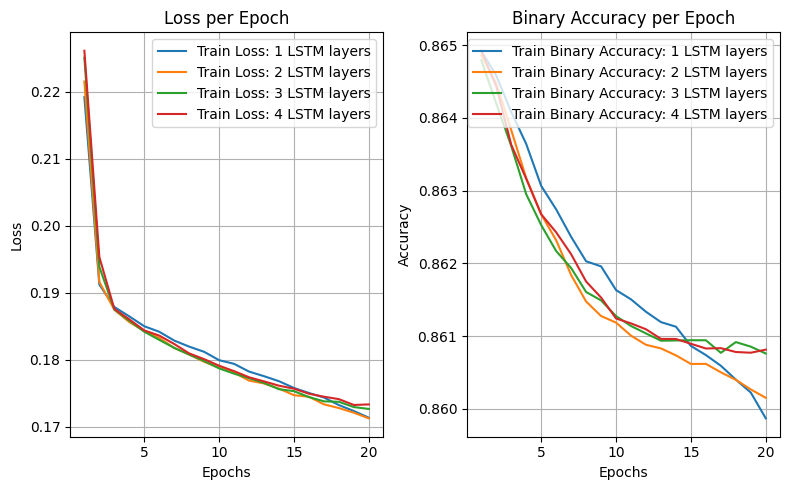

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
for num_layers, history in all_histories.items():
    epochs = range(1, len(history['loss']) + 1)
    axs[0].plot(epochs, history['loss'], label=f'Train Loss: {num_layers} LSTM layers')
axs[0].set_title('Loss per Epoch')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()
for num_layers, history in all_histories.items():
    epochs = range(1, len(history['binary_accuracy']) + 1)
    axs[1].plot(epochs, history['binary_accuracy'], label=f'Train Binary Accuracy: {num_layers} LSTM layers')
axs[1].set_title('Binary Accuracy per Epoch')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()
